In [25]:
%load_ext autoreload
%autoreload 2


# 1. Pre-processing

In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import pytorch_tabnet.tab_model
import pytorch_tabnet
import pytorch_tabnet.tab_network
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline
import importlib

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())
    
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)
        
        
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

con_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]

'''
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
'''
base_auc = 0.9275363726026278
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0

base_auc_2 = 0.9313200431309823
base_acc_2 = 0.8754208754208754
beat_auc_2 = 0
beat_acc_2 = 0

'''
EXPLAIN:
    - base_auc: roc auc score of the pretrained version of original model
    - base_auc_2: roc auc score of the TabNet modified version with no pretraining
    => Now we test the TabNet modified version with pretraining
'''

#### Customized train, valid, test
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

astract_model.py, con_idxs =  Field(name=None,type=None,default=<dataclasses._MISSING_TYPE object at 0x000001925C28B070>,default_factory=<class 'list'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=None)
Running Yen model
File already exists.
39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# 2. Pretraining

In [2]:
'''
First, I test with the same model, with con embedding in the TabNet pretrainer, and with con embedding in TabNet classifier.
'''

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    con_idxs=con_idxs,
    con_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
)
max_epochs = 1000 if not os.getenv("CI", False) else 2

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,

) 




unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 5.08253 | val_0_unsup_loss: 1.61394 |  0:00:02s
epoch 1  | loss: 1.43613 | val_0_unsup_loss: 1.33816 |  0:00:05s
epoch 2  | loss: 1.25663 | val_0_unsup_loss: 1.27227 |  0:00:08s
epoch 3  | loss: 1.23927 | val_0_unsup_loss: 1.25807 |  0:00:10s
epoch 4  | loss: 1.23549 | val_0_unsup_loss: 1.25515 |  0:00:13s
epoch 5  | loss: 1.23098 | val_0_unsup_loss: 1.25082 |  0:00:16s
epoch 6  | loss: 1.23246 | val_0_unsup_loss: 1.24872 |  0:00:21s
epoch 7  | loss: 1.22279 | val_0_unsup_loss: 1.24964 |  0:00:24s
epoch 8  | loss: 1.22656 | val_0_unsup_loss: 1.24857 |  0:00:28s
epoch 9  | loss: 1.23126 | val_0_unsup_loss: 1.24737 |  0:00:31s
epoch 10 | loss: 1.22081 | val_0_unsup_loss: 1.24488 |  0:00:34s
epoch 11 | loss: 1.22725 | va

### Reconstruct X_train, y_train

In [3]:
# Make reconstruction from a dataset
reconstructed_X_train, embedded_X_train = unsupervised_model.predict(X_train)
assert(reconstructed_X_train.shape==embedded_X_train.shape)

In [4]:
X_train_concat = np.concatenate((reconstructed_X_train, embedded_X_train), axis = 0)
X_train_concat.shape

(52144, 14)

In [5]:
y_train_concat = np.concatenate((y_train, y_train), axis = 0)
y_train_concat.shape

(52144,)

### Reconstruct X_valid, y_valid

In [6]:
# Make reconstruction from a dataset
reconstructed_X_valid, embedded_X_valid = unsupervised_model.predict(X_valid)
assert(reconstructed_X_valid.shape==embedded_X_valid.shape)

In [7]:
X_valid_concat = np.concatenate((reconstructed_X_valid, embedded_X_valid), axis = 0)
X_valid_concat.shape

(6442, 14)

In [8]:
y_valid_concat = np.concatenate((y_valid, y_valid), axis = 0)
y_valid_concat.shape

(6442,)

### Embed X_test

In [ ]:
_, embedded_X_test = unsupervised_model.predict(X_test)
X_test = embedded_X_test

In [14]:
X_test.shape

(3267, 14)

### Training 

#### Hyperparamters note:
       """Train a neural network stored in self.network
        Using train_dataloader for training data and
        valid_dataloader for validation.

        Parameters
        ----------
        X_train : np.ndarray
            Train set
        y_train : np.array
            Train targets
        eval_set : list of tuple
            List of eval tuple set (X, y).
            The last one is used for early stopping
        eval_name : list of str
            List of eval set names.
        eval_metric : list of str
            List of evaluation metrics.
            The last metric is used for early stopping.
        loss_fn : callable or None
            a PyTorch loss function
        weights : bool or dictionnary
            0 for no balancing
            1 for automated balancing
            dict for custom weights per class
        max_epochs : int
            Maximum number of epochs during training
        patience : int
            Number of consecutive non improving epoch before early stopping
        batch_size : int
            Training batch size
        virtual_batch_size : int
            Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
        num_workers : int
            Number of workers used in torch.utils.data.DataLoader
        drop_last : bool
            Whether to drop last batch during training
        callbacks : list of callback function
            List of custom callbacks
        pin_memory: bool
            Whether to set pin_memory to True or False during training
        from_unsupervised: unsupervised trained model
            Use a previously self supervised model as starting weights
        """

In [16]:
# NO LOOP
max_epochs = 7700 if not os.getenv("CI", False) else 2


clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

clf.fit(
        X_train=X_train_concat, y_train=y_train_concat,
        eval_set=[(X_train_concat, y_train_concat), (X_valid_concat, y_valid_concat)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        from_unsupervised=loaded_pretrain
        )


Device used : cpu
In abstract_model.py, _set_network, con_idxs =  [2]
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
Loading weights from unsupervised pretraining



D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_idxs changed from [] to [2]
  warnings.warn(wrn_msg)


IndexError: index out of range in self

In [10]:
max_epochs = 7700 if not os.getenv("CI", False) else 2
auc = []
acc = []
for i in range(3, 17):
    clf = TabNetClassifier(cat_idxs = [],
                           cat_emb_dim = 1,
                           con_idxs = range(len(X_train_concat[0])),
                           con_emb_dim = i,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=2e-2),
                           scheduler_params={"step_size":50, # how to use learning rate scheduler
                                             "gamma":0.9},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='entmax' # "sparsemax"
                          )

    clf.fit(
            X_train=X_train_concat, y_train=y_train_concat,
            eval_set=[(X_train_concat, y_train_concat), (X_valid_concat, y_valid_concat)],
            eval_name=['train', 'valid'],
            eval_metric=['auc'],
            max_epochs=max_epochs , patience=20,
            batch_size=1024, virtual_batch_size=128,
            num_workers=0,
            weights=1,
            drop_last=False,
            )
    preds_class = clf.predict(X_test)
    preds = clf.predict_proba(X_test)
    test_acc = accuracy_score(y_test, preds_class)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
    acc.append(test_acc)
    auc.append(test_auc)
    print("With i =", i)
    print("acc:", test_acc)
    print("auc:", test_auc)


Device used : cpu
In abstract_model.py, _set_network, con_idxs =  range(0, 14)
Con idxs =  range(0, 14)
Cat_idxs= []
Con_idxs= range(0, 14)
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 0.52066 | train_auc: 0.83873 | valid_auc: 0.8445  |  0:00:08s
epoch 1  | loss: 0.46296 | train_auc: 0.84362 | valid_auc: 0.85104 |  0:00:19s
epoch 2  | loss: 0.45809 | train_auc: 0.85029 | valid_auc: 0.85761 |  0:00:35s
epoch 3  | loss: 0.45491 | train_auc: 0.83221 | valid_auc: 0.84083 |  0:00:45s
epoch 4  | loss: 0.44796 | train_auc: 0.86056 | valid_auc: 0.86813 |  0:00:54s
epoch 5  | loss: 0.44683 | train_auc: 0.86445 | valid_auc: 0.87285 |  0:01:03s
epoch 6  | loss: 0.45022 | train_auc: 0.87073 | valid_auc: 0.87827 |  0:01:12s
epoch 7  | loss: 0.44111 | train_auc: 0.87209 | valid_auc: 0.8785  |  0:01:22s
epoch 8  | loss: 0.43963 | train_auc: 0.87407 | valid_auc: 0.88012 |  0:01:31s
epoch 9  | loss: 0.43771 | train_auc: 0.87542 | valid_auc: 0.88212 |  0:01:39s
epoch 10 | loss: 0.43863 |

epoch 38 | loss: 0.42256 | train_auc: 0.88104 | valid_auc: 0.88376 |  0:06:02s
epoch 39 | loss: 0.42635 | train_auc: 0.87714 | valid_auc: 0.88074 |  0:06:10s
epoch 40 | loss: 0.42548 | train_auc: 0.87151 | valid_auc: 0.87496 |  0:06:19s
epoch 41 | loss: 0.43063 | train_auc: 0.88027 | valid_auc: 0.88375 |  0:06:28s
epoch 42 | loss: 0.42246 | train_auc: 0.87857 | valid_auc: 0.88397 |  0:06:36s
epoch 43 | loss: 0.42915 | train_auc: 0.88234 | valid_auc: 0.88694 |  0:06:45s
epoch 44 | loss: 0.4286  | train_auc: 0.88347 | valid_auc: 0.88497 |  0:06:53s
epoch 45 | loss: 0.42378 | train_auc: 0.88296 | valid_auc: 0.88384 |  0:07:02s
epoch 46 | loss: 0.42563 | train_auc: 0.84427 | valid_auc: 0.84782 |  0:07:11s
epoch 47 | loss: 0.42161 | train_auc: 0.87046 | valid_auc: 0.87386 |  0:07:21s
epoch 48 | loss: 0.42566 | train_auc: 0.88368 | valid_auc: 0.88498 |  0:07:31s
epoch 49 | loss: 0.42468 | train_auc: 0.88268 | valid_auc: 0.88625 |  0:07:41s
epoch 50 | loss: 0.42697 | train_auc: 0.88359 | vali

epoch 19 | loss: 0.43222 | train_auc: 0.87781 | valid_auc: 0.88433 |  0:03:03s
epoch 20 | loss: 0.43387 | train_auc: 0.86066 | valid_auc: 0.86374 |  0:03:12s
epoch 21 | loss: 0.43602 | train_auc: 0.87257 | valid_auc: 0.87723 |  0:03:21s
epoch 22 | loss: 0.44052 | train_auc: 0.87595 | valid_auc: 0.8824  |  0:03:31s
epoch 23 | loss: 0.4361  | train_auc: 0.87357 | valid_auc: 0.88005 |  0:03:40s
epoch 24 | loss: 0.43572 | train_auc: 0.87871 | valid_auc: 0.88396 |  0:03:49s
epoch 25 | loss: 0.43104 | train_auc: 0.87718 | valid_auc: 0.88105 |  0:03:59s
epoch 26 | loss: 0.43152 | train_auc: 0.88127 | valid_auc: 0.88665 |  0:04:08s
epoch 27 | loss: 0.43328 | train_auc: 0.87991 | valid_auc: 0.88327 |  0:04:18s
epoch 28 | loss: 0.43141 | train_auc: 0.87637 | valid_auc: 0.8794  |  0:04:27s
epoch 29 | loss: 0.42667 | train_auc: 0.87398 | valid_auc: 0.87654 |  0:04:36s
epoch 30 | loss: 0.43005 | train_auc: 0.88078 | valid_auc: 0.88516 |  0:04:45s
epoch 31 | loss: 0.42655 | train_auc: 0.87752 | vali

epoch 71 | loss: 0.41847 | train_auc: 0.88307 | valid_auc: 0.88191 |  0:11:10s
epoch 72 | loss: 0.4161  | train_auc: 0.8796  | valid_auc: 0.87859 |  0:11:22s
epoch 73 | loss: 0.41556 | train_auc: 0.88132 | valid_auc: 0.8822  |  0:11:33s
epoch 74 | loss: 0.42102 | train_auc: 0.88717 | valid_auc: 0.88865 |  0:11:43s
epoch 75 | loss: 0.41689 | train_auc: 0.86779 | valid_auc: 0.87368 |  0:11:53s
epoch 76 | loss: 0.42796 | train_auc: 0.87873 | valid_auc: 0.8824  |  0:12:04s
epoch 77 | loss: 0.42697 | train_auc: 0.87855 | valid_auc: 0.88181 |  0:12:14s
epoch 78 | loss: 0.42306 | train_auc: 0.88616 | valid_auc: 0.88703 |  0:12:24s
epoch 79 | loss: 0.41727 | train_auc: 0.88622 | valid_auc: 0.88584 |  0:12:33s
epoch 80 | loss: 0.41887 | train_auc: 0.8783  | valid_auc: 0.88076 |  0:12:42s
epoch 81 | loss: 0.41813 | train_auc: 0.88255 | valid_auc: 0.886   |  0:12:51s
epoch 82 | loss: 0.41833 | train_auc: 0.88318 | valid_auc: 0.88341 |  0:13:02s
epoch 83 | loss: 0.41574 | train_auc: 0.88628 | vali

epoch 75 | loss: 0.4179  | train_auc: 0.88679 | valid_auc: 0.88666 |  0:18:49s
epoch 76 | loss: 0.4222  | train_auc: 0.88907 | valid_auc: 0.88639 |  0:19:04s

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_auc = 0.88825
Best weights from best epoch are automatically used!
With i = 7
acc: 0.7799204162840526
auc: 0.9001829489531539
Device used : cpu
In abstract_model.py, _set_network, con_idxs =  range(0, 14)
Con idxs =  range(0, 14)
Cat_idxs= []
Con_idxs= range(0, 14)
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 0.54122 | train_auc: 0.84404 | valid_auc: 0.85464 |  0:00:16s
epoch 1  | loss: 0.46583 | train_auc: 0.85016 | valid_auc: 0.85752 |  0:00:32s
epoch 2  | loss: 0.46085 | train_auc: 0.85372 | valid_auc: 0.86082 |  0:00:47s
epoch 3  | loss: 0.45886 | train_auc: 0.8578  | valid_auc: 0.866   |  0:01:01s
epoch 4  | loss: 0.45729 | train_auc: 0.85721 | valid_auc: 0.86423 |  0:01:15s
epoch 5  | loss: 0.45398 | train_auc: 0.86283 | valid_auc: 0.869

epoch 50 | loss: 0.42637 | train_auc: 0.879   | valid_auc: 0.8808  |  0:13:03s
epoch 51 | loss: 0.42236 | train_auc: 0.8696  | valid_auc: 0.87742 |  0:13:19s
epoch 52 | loss: 0.42758 | train_auc: 0.8841  | valid_auc: 0.88717 |  0:13:35s
epoch 53 | loss: 0.42285 | train_auc: 0.87613 | valid_auc: 0.87682 |  0:13:52s
epoch 54 | loss: 0.42768 | train_auc: 0.87752 | valid_auc: 0.88054 |  0:14:07s
epoch 55 | loss: 0.42232 | train_auc: 0.87851 | valid_auc: 0.88026 |  0:14:23s
epoch 56 | loss: 0.42139 | train_auc: 0.88215 | valid_auc: 0.88164 |  0:14:42s
epoch 57 | loss: 0.43055 | train_auc: 0.87931 | valid_auc: 0.88085 |  0:15:00s
epoch 58 | loss: 0.4207  | train_auc: 0.88405 | valid_auc: 0.8862  |  0:15:19s
epoch 59 | loss: 0.42412 | train_auc: 0.88216 | valid_auc: 0.88436 |  0:15:36s
epoch 60 | loss: 0.42351 | train_auc: 0.88593 | valid_auc: 0.8865  |  0:15:54s
epoch 61 | loss: 0.42449 | train_auc: 0.88159 | valid_auc: 0.88519 |  0:16:12s
epoch 62 | loss: 0.42587 | train_auc: 0.88313 | vali

epoch 34 | loss: 0.42472 | train_auc: 0.87905 | valid_auc: 0.88502 |  0:11:25s
epoch 35 | loss: 0.4278  | train_auc: 0.8829  | valid_auc: 0.88849 |  0:11:44s
epoch 36 | loss: 0.42263 | train_auc: 0.8847  | valid_auc: 0.88727 |  0:12:04s
epoch 37 | loss: 0.42526 | train_auc: 0.88262 | valid_auc: 0.887   |  0:12:22s
epoch 38 | loss: 0.42341 | train_auc: 0.88395 | valid_auc: 0.88682 |  0:12:44s
epoch 39 | loss: 0.42445 | train_auc: 0.88406 | valid_auc: 0.89    |  0:13:05s
epoch 40 | loss: 0.42377 | train_auc: 0.88232 | valid_auc: 0.88485 |  0:13:24s
epoch 41 | loss: 0.4271  | train_auc: 0.88333 | valid_auc: 0.88482 |  0:13:45s
epoch 42 | loss: 0.42108 | train_auc: 0.88208 | valid_auc: 0.88469 |  0:14:06s
epoch 43 | loss: 0.42311 | train_auc: 0.88257 | valid_auc: 0.88577 |  0:14:27s
epoch 44 | loss: 0.42418 | train_auc: 0.88355 | valid_auc: 0.88768 |  0:14:47s
epoch 45 | loss: 0.42031 | train_auc: 0.87358 | valid_auc: 0.87854 |  0:15:08s
epoch 46 | loss: 0.42369 | train_auc: 0.87307 | vali

epoch 73 | loss: 0.4187  | train_auc: 0.88877 | valid_auc: 0.88851 |  0:18:52s
epoch 74 | loss: 0.41658 | train_auc: 0.88715 | valid_auc: 0.88588 |  0:19:05s
epoch 75 | loss: 0.41407 | train_auc: 0.88574 | valid_auc: 0.88528 |  0:19:18s
epoch 76 | loss: 0.42333 | train_auc: 0.88668 | valid_auc: 0.88698 |  0:19:31s
epoch 77 | loss: 0.41494 | train_auc: 0.88881 | valid_auc: 0.88491 |  0:19:43s
epoch 78 | loss: 0.41655 | train_auc: 0.88865 | valid_auc: 0.88766 |  0:19:56s
epoch 79 | loss: 0.41572 | train_auc: 0.88969 | valid_auc: 0.88611 |  0:20:08s
epoch 80 | loss: 0.42003 | train_auc: 0.88795 | valid_auc: 0.88593 |  0:20:21s
epoch 81 | loss: 0.41685 | train_auc: 0.88676 | valid_auc: 0.88671 |  0:20:33s
epoch 82 | loss: 0.41765 | train_auc: 0.89048 | valid_auc: 0.88559 |  0:20:46s
epoch 83 | loss: 0.41354 | train_auc: 0.89023 | valid_auc: 0.88649 |  0:20:59s
epoch 84 | loss: 0.41563 | train_auc: 0.88924 | valid_auc: 0.88774 |  0:21:12s
epoch 85 | loss: 0.41544 | train_auc: 0.8909  | vali

epoch 5  | loss: 0.45532 | train_auc: 0.86752 | valid_auc: 0.87183 |  0:01:41s
epoch 6  | loss: 0.45261 | train_auc: 0.86546 | valid_auc: 0.87038 |  0:01:58s
epoch 7  | loss: 0.44716 | train_auc: 0.86951 | valid_auc: 0.87679 |  0:02:14s
epoch 8  | loss: 0.44967 | train_auc: 0.872   | valid_auc: 0.87764 |  0:02:34s
epoch 9  | loss: 0.43968 | train_auc: 0.87358 | valid_auc: 0.87825 |  0:02:55s
epoch 10 | loss: 0.44222 | train_auc: 0.87088 | valid_auc: 0.87471 |  0:03:14s
epoch 11 | loss: 0.4399  | train_auc: 0.87251 | valid_auc: 0.87635 |  0:03:31s
epoch 12 | loss: 0.43813 | train_auc: 0.8749  | valid_auc: 0.87849 |  0:03:47s
epoch 13 | loss: 0.43862 | train_auc: 0.87541 | valid_auc: 0.87885 |  0:04:04s
epoch 14 | loss: 0.43738 | train_auc: 0.87617 | valid_auc: 0.88001 |  0:04:21s
epoch 15 | loss: 0.43779 | train_auc: 0.8741  | valid_auc: 0.87732 |  0:04:39s
epoch 16 | loss: 0.43816 | train_auc: 0.87498 | valid_auc: 0.8809  |  0:04:55s
epoch 17 | loss: 0.43739 | train_auc: 0.87478 | vali

epoch 45 | loss: 0.42147 | train_auc: 0.88448 | valid_auc: 0.88648 |  0:12:25s
epoch 46 | loss: 0.42434 | train_auc: 0.88635 | valid_auc: 0.88834 |  0:12:42s
epoch 47 | loss: 0.42258 | train_auc: 0.88401 | valid_auc: 0.88503 |  0:12:57s
epoch 48 | loss: 0.42002 | train_auc: 0.88525 | valid_auc: 0.88659 |  0:13:15s
epoch 49 | loss: 0.42356 | train_auc: 0.88488 | valid_auc: 0.88512 |  0:13:30s
epoch 50 | loss: 0.42089 | train_auc: 0.88318 | valid_auc: 0.88233 |  0:13:49s
epoch 51 | loss: 0.41793 | train_auc: 0.88166 | valid_auc: 0.88292 |  0:14:07s
epoch 52 | loss: 0.42122 | train_auc: 0.88622 | valid_auc: 0.88708 |  0:14:23s
epoch 53 | loss: 0.41889 | train_auc: 0.88797 | valid_auc: 0.88911 |  0:14:40s
epoch 54 | loss: 0.41908 | train_auc: 0.88779 | valid_auc: 0.8881  |  0:14:56s
epoch 55 | loss: 0.42128 | train_auc: 0.88298 | valid_auc: 0.88536 |  0:15:11s
epoch 56 | loss: 0.41884 | train_auc: 0.86998 | valid_auc: 0.87181 |  0:15:29s
epoch 57 | loss: 0.42276 | train_auc: 0.87811 | vali

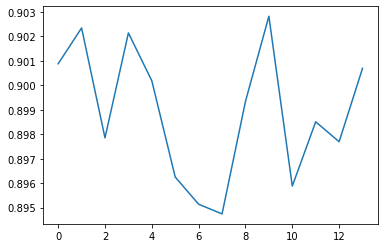

In [14]:
plt.plot(auc)

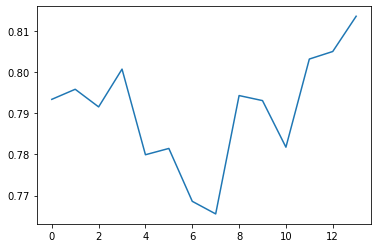

In [15]:
plt.plot(acc)

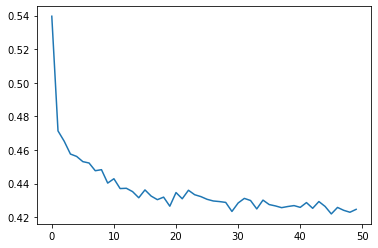

In [11]:
# plot losses
plt.plot(clf.history['loss'])

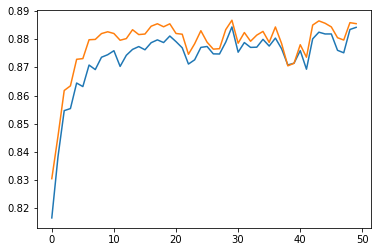

In [12]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

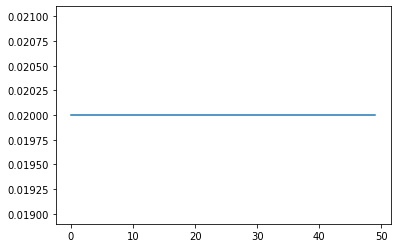

In [13]:
# plot learning rates
plt.plot(clf.history['lr'])

In [17]:
preds_class = clf.predict(X_test)
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_test, preds_class)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print("acc:", test_acc)
print("auc:", test_auc)

acc: 0.7921640648913376
auc: 0.9003827619159559


In [9]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

In [11]:
unsupervised_explain_matrix

array([[2.54740193e-02, 2.11515818e-02, 1.05864015e+00, ...,
        9.54220369e-02, 8.39035958e-03, 5.73815918e-03],
       [0.00000000e+00, 2.20316220e-02, 1.09674400e+00, ...,
        3.30955945e-02, 5.39893545e-02, 2.86211185e-02],
       [0.00000000e+00, 1.34952385e-02, 1.65080447e+00, ...,
        6.77612349e-02, 2.85544345e-04, 9.07552615e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 5.18298169e+00, ...,
        7.35561609e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.74242255e+00, ...,
        2.63292998e-01, 0.00000000e+00, 0.00000000e+00],
       [4.16090973e-02, 0.00000000e+00, 6.21136870e+00, ...,
        8.99581730e-01, 0.00000000e+00, 0.00000000e+00]])

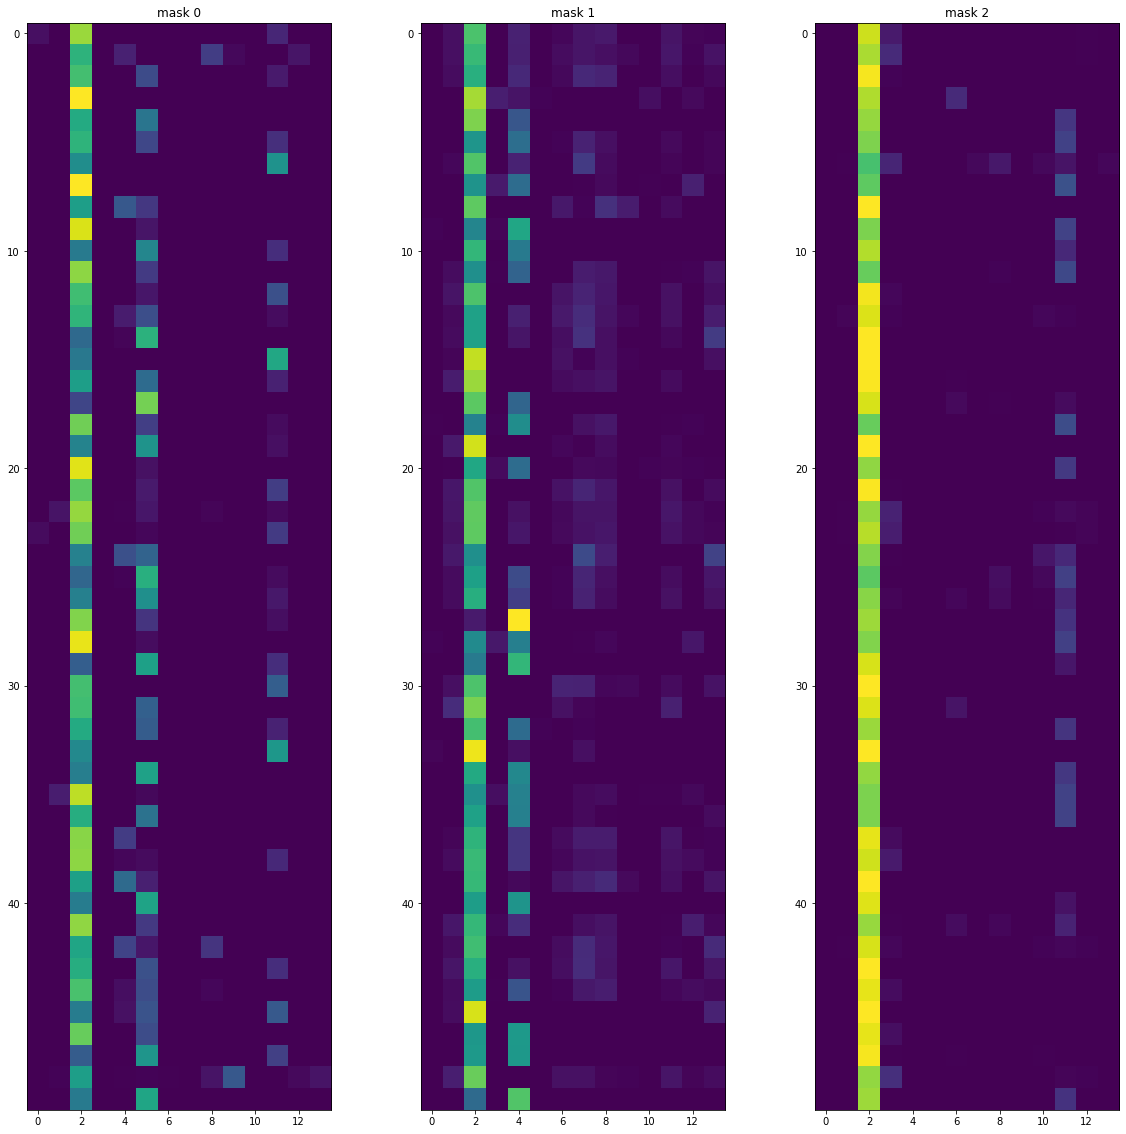

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [14]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip
Device used : cpu
Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14


In [15]:
unsupervised_model.get_params()

{'cat_dims': [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42],
 'cat_emb_dim': 1,
 'cat_idxs': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'clip_value': 1,
 'con_emb_dim': 35,
 'con_idxs': [2],
 'device_name': 'auto',
 'dropout': 1,
 'embed_dim': 512,
 'epsilon': 1e-15,
 'forward_expansion': 1,
 'gamma': 1.3,
 'heads': 1,
 'input_dim': 14,
 'lambda_sparse': 0.001,
 'mask_type': 'entmax',
 'momentum': 0.02,
 'n_a': 8,
 'n_d': 8,
 'n_indep_decoder': 1,
 'n_independent': 2,
 'n_shared': 2,
 'n_shared_decoder': 1,
 'n_steps': 3,
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02},
 'output_dim': None,
 'scheduler_fn': None,
 'scheduler_params': {},
 'seed': 0,
 'verbose': 1}

In [33]:
loaded_pretrain

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, con_idxs=[2], con_emb_dim=35, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=14, output_dim=None, embed_dim=512, dropout=1, forward_expansion=1, heads=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [34]:
unsupervised_model

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, con_idxs=[2], con_emb_dim=35, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=14, output_dim=None, embed_dim=512, dropout=1, forward_expansion=1, heads=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

# 3. Classifier

In [35]:
max_epochs = 7700 if not os.getenv("CI", False) else 2


clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        from_unsupervised=loaded_pretrain
        )


Device used : cpu
In abstract_model.py, _set_network, con_idxs =  [2]
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
Loading weights from unsupervised pretraining



D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_emb_dim changed from 1 to 35
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_idxs changed from [] to [2]
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69546 | train_auc: 0.60583 | valid_auc: 0.61842 |  0:00:04s
epoch 1  | loss: 0.58377 | train_auc: 0.77838 | valid_auc: 0.78961 |  0:00:08s
epoch 2  | loss: 0.50047 | train_auc: 0.83679 | valid_auc: 0.854   |  0:00:12s
epoch 3  | loss: 0.45362 | train_auc: 0.86865 | valid_auc: 0.88007 |  0:00:17s
epoch 4  | loss: 0.42371 | train_auc: 0.8861  | valid_auc: 0.89017 |  0:00:21s
epoch 5  | loss: 0.40672 | train_auc: 0.89792 | valid_auc: 0.89936 |  0:00:25s
epoch 6  | loss: 0.38559 | train_auc: 0.90513 | valid_auc: 0.90781 |  0:00:29s
epoch 7  | loss: 0.37616 | train_auc: 0.9089  | valid_auc: 0.90706 |  0:00:33s
epoch 8  | loss: 0.36481 | train_auc: 0.91055 | valid_auc: 0.90773 |  0:00:38s
epoch 9  | loss: 0.35733 | train_auc: 0.91738 | valid_auc: 0.9165  |  0:00:43s
epoch 10 | loss: 0.35061 | train_auc: 0.91973 | valid_auc: 0.91791 |  0:00:47s
epoch 11 | loss: 0.34506 | train_auc: 0.91677 | valid_auc: 0.91316 |  0:00:52s
epoch 12 | loss: 0.34911 | train_auc: 0.92361 | vali

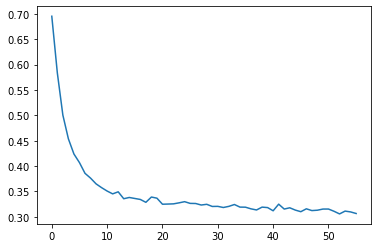

In [36]:
# plot losses
plt.plot(clf.history['loss'])

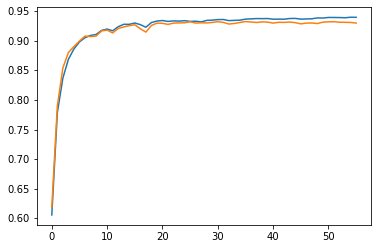

In [37]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

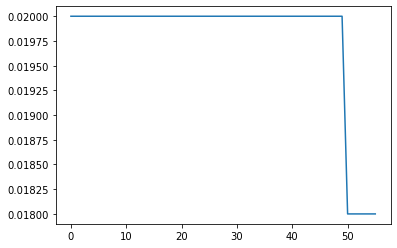

In [38]:
# plot learning rates
plt.plot(clf.history['lr'])

In [39]:
preds_class = clf.predict(X_test)
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_test, preds_class)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print("acc:", test_acc)
print("auc:", test_auc)

acc: 0.8243036424854606
auc: 0.9311197191375846


In [40]:
clf.feature_importances_

array([0.00000000e+00, 6.17697807e-03, 2.67272908e-01, 4.45911382e-03,
       7.60578631e-02, 9.95226252e-02, 1.80366080e-03, 0.00000000e+00,
       2.52882012e-05, 7.17992487e-03, 4.54585135e-01, 4.79427741e-02,
       2.09781954e-02, 1.39955330e-02])